<a id = "intro"></a>
# Problem Definition
<br>
The task involves developing an algorithm to classify histopathologic images for the detection of metastatic cancer. The dataset is derived from the PatchCamelyon collection, which consists entirely of unique image patches. In addition to the image data, there is a complementary CSV file that contains metadata: each row includes an image identifier and its corresponding label. Images labeled as non-cancerous are assigned a value of `1`, while those labeled as cancerous are marked with a value of `0`.

This project serves as a submission for the Histopathologic Cancer Detection competition hosted on Kaggle.

To begin, we will import all the essential libraries and modules required for this implementation.

In [39]:
# Import necessary libraries and modules
import os
import gc
import numpy as np
import pandas as pd
import tifffile as tiff
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score
import cv2
import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
# Importing Tensorflow Libraries

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [41]:
os.getcwd()

'/kaggle/working'

In [42]:
os.listdir(os.getcwd())

['.virtual_documents', 'base_dir']

In [43]:
# Get the directories and data
os.listdir('../input/')

['histopathologic-cancer-detection']

In [44]:
os.listdir('../input/histopathologic-cancer-detection')

['sample_submission.csv', 'train_labels.csv', 'test', 'train']

In [45]:
dataset = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
train_path = '/kaggle/input/train/'
test_path = '/kaggle/input/test/'
# quick look at the label stats - there are two: 0 (not cancerous) and 1 (cancerous)
print(dataset['label'].value_counts())

label
0    130908
1     89117
Name: count, dtype: int64


In [46]:
'''
Get dataset columns' names
There are two: the images' ids and the labels (0 for non-canceerous images, 1 otherwise)
'''
dataset.columns

Index(['id', 'label'], dtype='object')

Get the shape of dataset containing all of the labels. There are two columns and 220,025 rows of image classification data.

In [47]:
print(dataset.shape)

(220025, 2)


In [48]:
dataset.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [49]:
dataset.tail()

,id,label
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0
220024,a81f84895ddcd522302ddf34be02eb1b3e5af1cb,1


In [50]:
# Take a look at the labels in the training data; there should be all unique id values
dataset['label'].unique()

array([0, 1])

In [51]:
# Get all value counts
dataset.value_counts()

id                                        label
00001b2b5609af42ab0ab276dd4cd41c3e7745b5  1        1
aafa66be401644d911bf216e6e3d3e7970f55194  1        1
aafb5b379c54b029f395eb664e052653a8d5c5db  1        1
aafbdfd08f338fa8eb59e76e4e5a026e81b1915b  0        1
aafcecc71fcc22a018c7966f629133dd6ad93ebd  1        1
                                                  ..
55b8cb133f5755df024ec0c46bc5579c9178bed1  0        1
55b8f6c58e3d6e719866cf76c0d5bc22840ad188  0        1
55b9081b80241e43db5d314e9c3327d8fc8bb68f  1        1
55b94ae30d2025a815c4729a97acdbd06f7398e4  1        1
ffffe55093358954f38bba4c35b6aa0ece86177c  0        1
Name: count, Length: 220025, dtype: int64

In [52]:
# Check if there are any null values in the dataset; there should be none
dataset.isnull().sum()

id       0
label    0
dtype: int64

In [53]:
# Get percentages of which labels are cancerous or not
zeros = len(dataset[dataset['label'] == 0])
ones = len(dataset[dataset['label'] == 1])
total = dataset.shape[0]

print("Value is 0:", zeros, '÷', total, '=', zeros / total)
print("Value is 1:", ones, '÷', total, '=', ones / total)

Value is 0: 130908 ÷ 220025 = 0.5949687535507329
Value is 1: 89117 ÷ 220025 = 0.40503124644926713


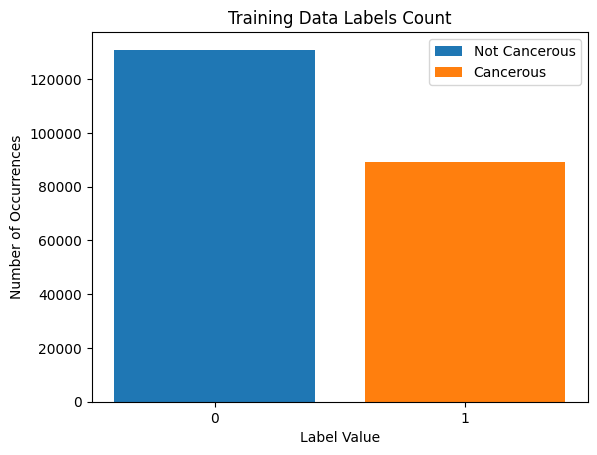

In [54]:
# Plot the distributions
# Credit can be attributed to the following notebook: 
# https://www.kaggle.com/code/alexandermaitken/cnn-cancer-detection?scriptVersionId=240762737&cellId=10
# 
# These should show the values from the previous code block

plt.bar('0', len(dataset[dataset['label'] == 0]))
plt.bar('1', len(dataset[dataset['label'] == 1]))
plt.xlabel("Label Value")
plt.ylabel("Number of Occurrences")
plt.title("Training Data Labels Count")
plt.legend(['Not Cancerous', 'Cancerous'])
plt.show()

About 59% of the data is listed as 0 or non-cancerous, with the other 41% being labeled as 1 or cancerous. 
<br>

In [55]:
dataset.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)


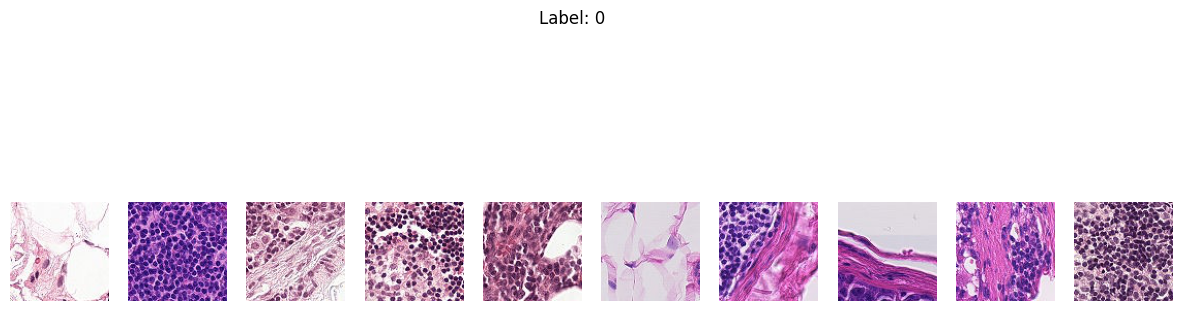

In [56]:
# Will need to alter base_path for training data since it is being used online via Kaggle
# Also shows the image of any one shape - or the number of pixels on any one image
base_path='/kaggle/input/histopathologic-cancer-detection/train'
def show_samples(df, label, n=10):
    samples = df[df['label'] == label].sample(n)
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    for img_id, ax in zip(samples['id'], axes):
        # img = get_image(img_id)
        path = os.path.join(base_path, f"{img_id}.tif")
        img = cv2.imread(path)
        print(img.shape)

        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')
    plt.suptitle(f"Label: {label}")
    plt.show()

# Show example images of non-cancerous images along with their respective shapes
# in pixels and colors type
show_samples(dataset, label=0)
plt.show()

(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)


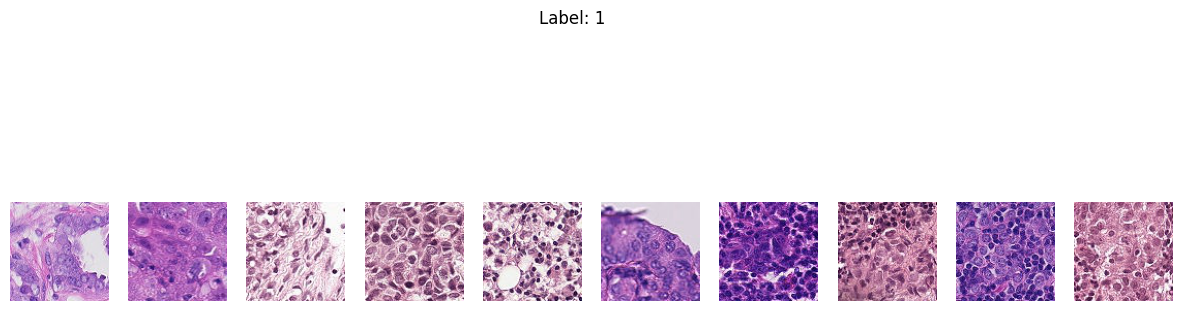

In [57]:
# Show example images of cancerous images along with their respective shapes
# in pixels and colors type
show_samples(dataset, label=1)
plt.show()

In [58]:
print("Total image count in TRAIN dataset: ", len(os.listdir("/kaggle/input/histopathologic-cancer-detection/train")))
print("Total image count in TEST dataset: ", len(os.listdir("/kaggle/input/histopathologic-cancer-detection/test")))

Total image count in TRAIN dataset:  220025
Total image count in TEST dataset:  57458


In [59]:
# Check for duplicates - there should be none - again check for uniques
print("\nDuplicate rows in training labels:")
print(dataset[dataset.duplicated(keep=False)])


Duplicate rows in training labels:
Empty DataFrame
Columns: [id, label]
Index: []


<a id = "data prep"></a>
# Data Preparation

To ensure efficiency and manageability, we will work with a subset of the full dataset. Instead of utilizing all 220,025 images, we will select a smaller sample for this analysis. For practicality and faster execution, a sample size of 50,000 images has been chosen. This represents less than one-fourth of the total dataset and strikes a balance between computational feasibility and data representation.

While the complete dataset contains over 220,000 images, processing such a large volume can be resource-intensive and time-consuming. By reducing the dataset to approximately 22% of its original size, we can streamline experimentation without compromising the ability to derive meaningful insights.

In [60]:
# Set sample size to 50,000
SAMPLE_SIZE=50000
# Set random states to 72
RANDOM_STATE=72

In [61]:
# Create the train and test sets with the sample size
dset0=dataset[dataset['label']==0].sample(SAMPLE_SIZE,random_state=RANDOM_STATE)
dset1=dataset[dataset['label']==1].sample(SAMPLE_SIZE,random_state=RANDOM_STATE)

# Put the dataset dataframes together
# update the dataset variable appropriately
dataset = pd.concat([dset0, dset1], axis=0).reset_index(drop=True)
# shuffle
dataset = shuffle(dataset)

# Check that both the label counts are 50,000 each
dataset['label'].value_counts()

label
0    50000
1    50000
Name: count, dtype: int64

In [62]:
dataset

,id,label
19966,60c3229bfc4dd33afd2957271da043bff5edd6ae,0
27264,8072de8c93f4e7648b57e596c3a01a7e821e7782,0
50266,c69937a65c3821e95f62ca87fd8b99526a07a865,1
41080,6e82cfc7a78af924e62ee22070cba8456575c795,0
32520,ef648d3a47851562a90009a9283eae0ecd5f134c,0
...,...,...
72036,7697e3037983160b50da64009cd4d355e706d4e5,1
43071,026f971268afb5139b2de307fd63ce7bec76d514,0
15653,988275c1ab5fac6a42a1c650a448b5ff1fa2d8f5,0
85072,3e4bdeea0c113dd5dc7c17adc4e906c8a6b76b58,1


To create a balanced and effective dataset for model development, an 80/20 split will be applied to the image data labels. From the total of 110,000 labels, 80,000 will be designated for training, while the remaining 20,000 will be allocated for testing. This approach ensures a clear division between the data used for training and evaluation.

In [63]:
# Create the 80-20 split for the image data labels

# The validation/actual labels - get the labels of either 0 or 1
y = dataset['label']

# Split the train data and test labels
train_data, train_labels = train_test_split(dataset, test_size=0.2, 
                                            random_state=RANDOM_STATE, stratify=y)

# Print out the shapes to verify sizes of the train and test datasets
print(train_data.shape, train_labels.shape)

(80000, 2) (20000, 2)


In [64]:
# Get a sample of train_data and train_labels
train_data.head()

,id,label
17560,610d97285c9fa679df5ccf215ac5a5b202e13ac2,0
7536,8609dbcce04ace6f9e7ddd1c1eea81526e0072c2,0
81591,a2f22ea0d0da1cdb110ae342156e7cc911465ed9,1
10127,4ff62c832d5d90ccb61d08ace7dabce690d26ad3,0
21731,9b3e3c24c800906d25320b6bcf8f3bfbf846d492,0


In [65]:
train_labels.head()

,id,label
37132,986a571c90d526bd8590ffbfc072dd74f31a6275,0
40130,aef90dd663f9f5e551fa3256d631565dd1d99ec6,0
60111,2cc3e693c3e185a80ec809a0460ec8005f246f0d,1
25918,2df04a61a152edfede047c596c2a96c8cf040972,0
9816,aa613bd6d5c561109ec5c777411b9af11f7315bf,0


In [66]:
train_data.columns, train_labels.columns

(Index(['id', 'label'], dtype='object'),
 Index(['id', 'label'], dtype='object'))

<a id = "data modeling"></a>
# Data Model
<br>
To organize the dataset effectively, we will establish a structured directory system. Begin by defining a base directory, which will serve as the root for all data operations. Within this base directory, create two primary subdirectories: one for training and another for validation.

Inside each of these subdirectories, further divide the data into two distinct categories: one for positive (cancerous) images and another for negative (non-cancerous) images. This hierarchical organization ensures that the data is cleanly segregated, making it easier to manage and process during model training and evaluation. By linking these directories to the base path, we create a streamlined pipeline that efficiently handles both image types and their associated metadata.

This systematic approach not only enhances clarity but also optimizes the workflow for training and validating the model.

In [67]:
base_dir = '/kaggle/working/base_dir'
train_dir = os.path.join(base_dir, 'train_dir')
val_dir = os.path.join(base_dir, 'val_dir')

In [68]:
# Use ImageDataGenerator and create a base folder called 'base' to test out model
# and determine what images are to be sorted as cancerous or not cancerous

# First, create the 'base' directory
# Should be removed and recreated if already there

import shutil

base_dir = '/kaggle/working/base_dir'
os.makedirs(base_dir, exist_ok=True)

**Organizing the Data Structure**

Within the base directory, create two main folders: one for training data (train_imgs) and another for validation data (val_imgs). Inside each of these folders, establish two subfolders labeled negative and positive. These subfolders will categorize the data based on whether the images depict non-cancerous or cancerous tissue.

train_imgs (Training Data)

* negative: Contains images and data representing non-cancerous tissue (no tumors).
* positive: Contains images and data depicting cancerous tissue (presence of tumors).

val_imgs (Validation Data)

* negative: Includes images and data associated with non-cancerous tissue (no tumors).
* positive: Includes images and data indicating the presence of cancerous tissue (tumors).

This hierarchical organization ensures that both training and validation datasets are neatly segmented into their respective categories, facilitating efficient processing and analysis during model development. By structuring the data in this manner, we maintain clarity and consistency throughout the workflow.

In [69]:
# Create a path to 'base' to make the two directories inside of base
# Make the directory train_dir
train_dir = os.path.join(base_dir, 'train_imgs')
os.makedirs(train_dir, exist_ok=True)

# Make the directory val_dir
val_dir = os.path.join(base_dir, 'val_imgs')
os.makedirs(val_dir, exist_ok=True)

In [70]:
# Create the subdirectories inside the train directories that were just created
negative = os.path.join(train_dir, 'negative')
os.makedirs(negative, exist_ok=True)
positive = os.path.join(train_dir, 'positive')
os.makedirs(positive, exist_ok=True)


# create new folders inside value directories that were just created
negative = os.path.join(val_dir, 'negative')
os.makedirs(negative, exist_ok=True)
positive = os.path.join(val_dir, 'positive')
os.makedirs(positive, exist_ok=True)

In [71]:
# check that the directories and subdirectories have been created
print(os.listdir('base_dir/train_imgs'))
print(os.listdir('base_dir/val_imgs'))

['negative', 'positive']
['negative', 'positive']


In [72]:
print(os.listdir('/kaggle/working/base_dir/train_imgs'))
print(os.listdir('/kaggle/working/base_dir/val_imgs'))

['negative', 'positive']
['negative', 'positive']


In [73]:
# dataset id set as index
dataset.set_index('id', inplace=True)

In [74]:
# Get the train data and train values in list form

list_train_data = list(train_data['id'])
list_train_values = list(train_labels['id'])

In [75]:
data_path_pull = "/kaggle/input/histopathologic-cancer-detection"

In [ ]:
# Transfer the train images

for image in list_train_data:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = dataset.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'negative'
    else:
        label = 'positive'
    
    # source path to image data path
    src = os.path.join(data_path_pull, 'train', fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


# Transfer the val images
for image in list_train_values:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = dataset.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'negative'
    else:
        label = 'positive'
    

    # source path to image
    src = os.path.join(data_path_pull, 'train', fname)
    # destination path to image
    dst = os.path.join(val_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


# check how many train images there are in each directory
print(len(os.listdir('base_dir/train_imgs/negative')))
print(len(os.listdir('base_dir/train_imgs/positive')))

In [ ]:
# Set up the generators and the appropriate directories/paths
train_path = 'base_dir/train_imgs'
valid_path = 'base_dir/val_imgs'
test_path = '/kaggle/input/histopathologic-cancer-detection/test'

# Splits were titled train_data (80), train_labels (20)

num_train_samples = len(train_data)
num_val_samples = len(train_labels)
train_batch_size = 10
val_batch_size = 10


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [ ]:
# Check the types on the train_steps and val_steps
type(train_steps), type(val_steps)

In [ ]:
# Since the model only takes integers, set the train_steps and val_steps to type int and then check it. 
train_steps = train_steps.astype(int)
val_steps= val_steps.astype(int)

In [ ]:
# Check once again
print(train_steps, train_steps.dtype)
print(val_steps, val_steps.dtype)

The size of one image is 96 pixels by 96 pixels, or 96^2. Take one length and make the default image size 96.

In [ ]:
IMAGE_SIZE = 96

datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

In [ ]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

In [ ]:
model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [ ]:
print(val_gen.class_indices)

<a id = "model"></a>
# Creating the Model
<br>
Creating model checkpoints and reduces learning rates whenever metrics stop improving. Building the model and fitting with the data.

In [ ]:
# Creating the model
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

# Set the model to 15 epochs
history = model.fit(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=15, verbose=1,
                   callbacks=callbacks_list)

In [ ]:
model.metrics_names

In [ ]:
val_loss= model.evaluate(test_gen, steps=len(train_labels))

print('val_loss:', val_loss)

In [ ]:
# Get loss and accuracy rates
print('val_loss:', val_loss[0])
print('val_accuracy', val_loss[1])

In [ ]:
# Get the loss and accuracy visuals
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.show()

In [ ]:
# make a prediction
predictions = model.predict(test_gen)

In [ ]:
predictions.shape

In [ ]:
data_preds = pd.DataFrame(predictions, columns=['negative', 'positive'])

data_preds.head()

In [ ]:
data_preds.shape

In [ ]:
len(test_gen.filenames)

In [ ]:
# Get the true labels
y_true = test_gen.classes

# Get the predicted labels as probabilities
y_pred = data_preds['positive']

In [ ]:
from sklearn.metrics import roc_auc_score
# Get ROC Score
roc_auc_score(y_true, y_pred)

In [ ]:
test_labels = test_gen.classes
test_labels.shape

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Get max value in row using argmax
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
# Print the label associated with each class
test_gen.class_indices

In [ ]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot()
plt.show()

In [ ]:
# Remove base_dir and create test_dir

shutil.rmtree('base_dir')

In [ ]:
# create test_dir
test_dir = 'test_dir'
os.makedirs(test_dir, exist_ok=True)

test_imgs = os.path.join(test_dir, 'test_imgs')
os.makedirs(test_imgs, exist_ok=True)

os.listdir('test_dir')

In [ ]:
# Transfer the test images into image_dir

test_list = os.listdir('../input/histopathologic-cancer-detection/test')

for image in test_list:
    
    fname = image
    
    # source path to image
    src = os.path.join('../input/histopathologic-cancer-detection/test', fname)
    # destination path to image
    dst = os.path.join(test_imgs, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
# check that the images are now in the test_images
# Total is 57458 images in the test_imgs folder
len(os.listdir('test_dir/test_imgs'))

<a id = "validation"></a>
# Testing and Validating the Model
<br>
Get the results from the test predictions and prepare to submit the file with the cancerous images and respective IDs.

In [ ]:
test_path ='test_dir'
# Adjust the path to put images into the test_imgs directory.
test_gen = datagen.flow_from_directory(test_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

In [ ]:
test_imgs_ct = 57458
test_predictions = model.predict(test_gen, steps=test_imgs_ct, verbose=1)

In [ ]:
len(test_predictions)

In [ ]:
# Create dataframe with all test's predictions
test_preds= pd.DataFrame(test_predictions, columns=['negative', 'positive'])
test_preds.head()

In [ ]:
# Get all filenames and add to the test_preds dataframe
test_fnames = test_gen.filenames

test_preds['fnames'] = test_fnames
test_preds.head()

In [ ]:
test_preds.fnames

In [ ]:
''' Similar to the sample submission, create an id column
Get rid of the 'test_imgs/' portion of each of the file names
to get just the file name as well as rid the '.tif' at the end of 
each cell in fname column
'''


def get_id(x):
    
    # split into a list
    a = x.split('/')
    # split into a list
    b = a[1].split('.')
    extracted_id = b[0]
    
    return extracted_id

test_preds['id'] = test_preds['fnames'].apply(get_id)

test_preds.head()

In [ ]:
# Sample of a fnames cell
test_preds['fnames'][0]

In [ ]:
# fnames column without the 'test_imgs/' at beginning or the trailing '.tif' at end
test_preds['id']

<a id = "Submit the file"></a>
# Submission

In [ ]:
# Get predicted labels with cancerous/positive images and their respective ids
y_pred = test_preds['positive']
img_ids = test_preds['id']

In [ ]:
# Create submission file dataframe
submission = pd.DataFrame({'id':img_ids, 
                           'label':y_pred, 
                          }).set_index('id')

# Create CSV file to be submitted
submission.to_csv('patch_preds.csv', columns=['label']) 
submission.head()

In [ ]:
# Remove all contents in test_dir
shutil.rmtree('test_dir')

In [ ]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
# Print the label associated with each class
test_gen.class_indices
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot()
plt.show()

In [ ]:
# Compare subplots from previous confusion matrix. 
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix')
plt.show()